<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/tf2/autoencoder-mnist-cnn-reconstruct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN / Reconstructing Autoencoder on MNIST data with TensorFlow 2

Sources for this notebook
* https://blog.keras.io/building-autoencoders-in-keras.html
* https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb

Latent Representation learns abstract concepts about inputs. We show two use cases
1. Semantic dimensionality reduction on images: using latent representation
2. modification of images: example is denoising

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

dpi = 96
# dpi = 300

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15, 8)
# mpl.rcParams["figure.dpi"] = dpi
mpl.rc('xtick', labelsize=15) 
mpl.rc('ytick', labelsize=15)

In [2]:
# Gives us a well defined version of tensorflow

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [3]:
import tensorflow as tf
print(tf.__version__)

2.1.0-rc1


In [0]:
tf.random.set_seed(42)

In [5]:
!nvidia-smi

Tue Dec 31 16:23:01 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import numpy as np
np.random.seed(42)

In [0]:
# https://github.com/AndreasMadsen/python-lrcurve
!pip install -q lrcurve 

In [0]:
from lrcurve import KerasLearningCurve

## MNIST data set

In [9]:
import numpy as np
from tensorflow.keras.datasets import mnist, fashion_mnist

x_res = 28
y_res = 28
image_size = x_res * y_res

# (x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [0]:
def plot_samples(x, y, n_samples=15, labels=None):
  figure = plt.figure()
  for i, index in enumerate(np.random.choice(x_test.shape[0], size=n_samples, replace=False)):
      ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
      ax.imshow(x[index].reshape(x_res, y_res), cmap="binary")
      if labels:
        ax.set_title("{}".format(labels[y[index]]))
      else:
        ax.set_title("{}".format(y[index]))

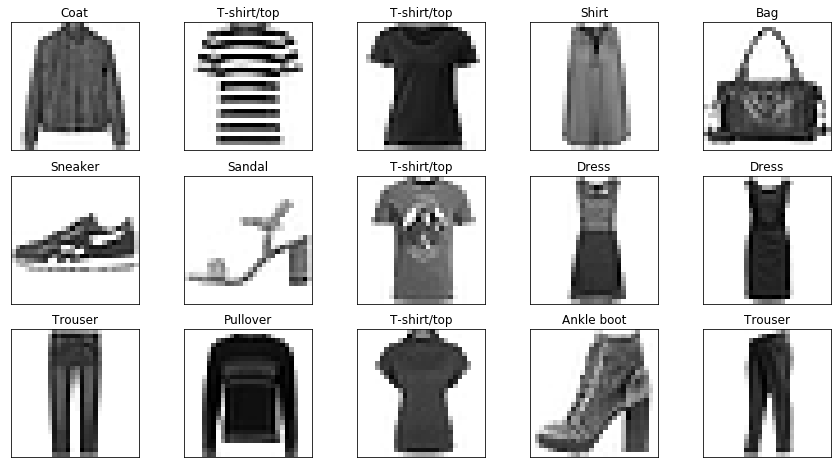

In [11]:
fashion_mnist_labels = ["T-shirt/top",  # index 0
                        "Trouser",      # index 1
                        "Pullover",     # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Sneaker",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9


plot_samples(x_train, y_train, labels=fashion_mnist_labels)

## CNN through Dense Lantent Space

In [0]:
from tensorflow import keras

@tf.function
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [13]:
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Reshape
from tensorflow.keras.models import Model, Sequential
from tensorflow import keras

encoding_dim = 128

conv_encoder = Sequential([
    Input(shape=(x_res, y_res)),
    Reshape((x_res, y_res, 1)),
    Conv2D(16, kernel_size=3, padding="same", activation="relu"),
    MaxPooling2D(pool_size=2),
    Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    MaxPooling2D(pool_size=2),
    Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(encoding_dim, activation="relu", 
          activity_regularizer=keras.regularizers.l2(1e-4)
         ),

])
conv_decoder = Sequential([
    Input(shape=(encoding_dim)),
    Reshape((1, 1, encoding_dim)),
    Conv2DTranspose(32, kernel_size=3, strides=2, padding="valid", activation="relu"),
    Conv2DTranspose(16, kernel_size=3, strides=2, padding="valid", activation="relu"),
    Conv2DTranspose(8, kernel_size=3, strides=2, padding="same", activation="relu"),
    Conv2DTranspose(1, kernel_size=3, strides=2, padding="same", activation="sigmoid"),
    Reshape((x_res, y_res))
])
conv_ae = Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer='adam', metrics=[rounded_accuracy])

conv_encoder.summary()
conv_decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0

In [14]:
%%time

BATCH_SIZE = 256
EPOCHS = 50

history = conv_ae.fit(x = x_train,
                    y = x_train,
                    validation_data=(x_test, x_test),
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 1min 39s, sys: 11.4 s, total: 1min 50s
Wall time: 1min 26s


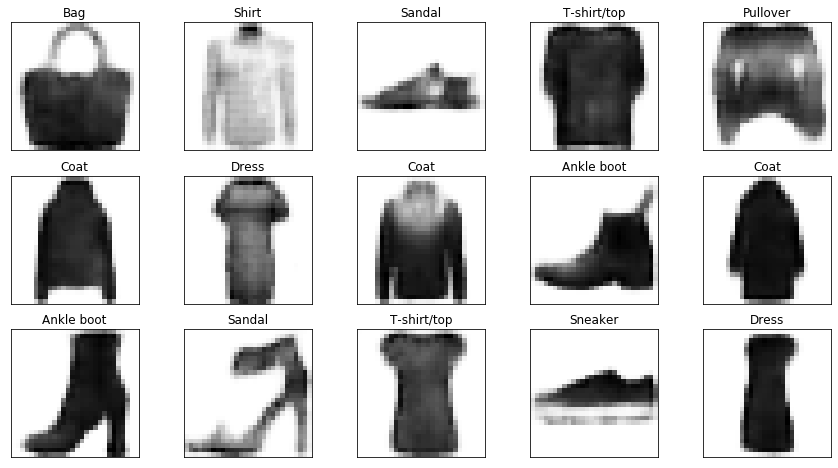

In [15]:
x_test_pred = conv_ae.predict(x_test)
plot_samples(x_test_pred, y_test, labels=fashion_mnist_labels)
# plot_samples(x_test_pred, y_test)

In [0]:
def compare_samples(x, x_pred, n_samples=5):
  figure = plt.figure()
  for i, index in enumerate(np.random.choice(x_test.shape[0], size=n_samples, replace=False)):
      ax = figure.add_subplot(2, n_samples, i + 1, xticks=[], yticks=[])
      ax.imshow(x[index].reshape(x_res, y_res), cmap="binary")
      ax = figure.add_subplot(2, n_samples, i + 1 + n_samples, xticks=[], yticks=[])
      ax.imshow(x_pred[index].reshape(x_res, y_res), cmap="binary")

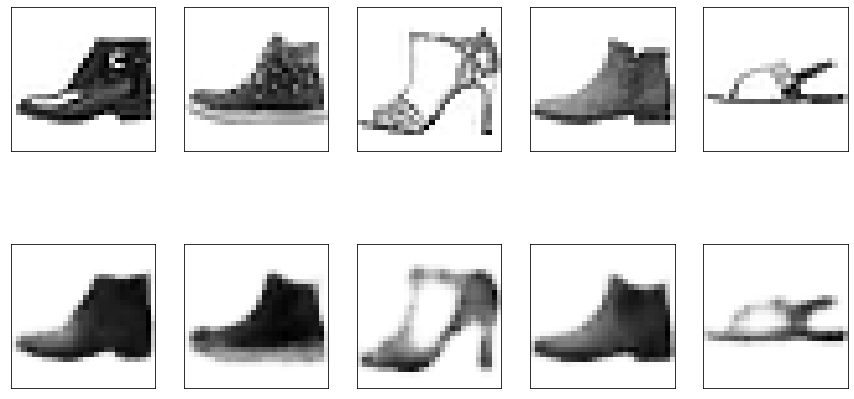

In [17]:
compare_samples(x_test, x_test_pred)

In [18]:
embedded_imgs = conv_encoder.predict(x_test)
embedded_imgs.shape

(10000, 64)

In [19]:
embedded_imgs[0]

array([0.        , 0.        , 0.        , 0.        , 0.6636485 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.28381747, 0.21727224, 0.16161208, 0.06675291, 0.18670852,
       0.17515352, 0.2165818 , 0.        , 0.        , 0.        ,
       0.0659599 , 0.06235874, 0.        , 0.17587614, 0.5091    ,
       0.3379384 , 0.25536233, 0.12607875, 0.5732738 , 0.22779375,
       0.        , 0.37170887, 0.        , 0.06327914, 0.        ,
       0.16123575, 0.4282863 , 0.11687994, 0.2455612 , 0.01303849,
       0.06766619, 0.14938173, 0.28765365, 0.18317744, 0.        ,
       0.        , 0.22573687, 0.29632384, 0.25437284, 0.32913342,
       0.15524858, 0.27824724, 0.        , 0.06473474, 0.15121667,
       0.        , 0.24724375, 0.        , 0.        , 0.2561274 ,
       0.        , 0.04043064, 0.        , 0.        ], dtype=float32)

In [20]:
tf.reduce_mean(embedded_imgs), tf.reduce_mean(encoding_dim - tf.cast(tf.math.count_nonzero(embedded_imgs, axis=1), tf.float32))

(<tf.Tensor: shape=(), dtype=float32, numpy=0.14330676>,
 <tf.Tensor: shape=(), dtype=float32, numpy=25.1645>)

In [21]:
%%time

import umap

if encoding_dim == 2:
  embeddings_2d = embedded_imgs
else:
  print('reducing dim using umap')
  reducer = umap.UMAP(random_state=42)
  embeddings_2d = reducer.fit_transform(embedded_imgs)

reducing dim using umap
CPU times: user 32.2 s, sys: 295 ms, total: 32.5 s
Wall time: 32 s


In [22]:
# just to make it a little easier for us for offsets etc.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
embeddings_2d = scaler.fit_transform(embeddings_2d)
embeddings_2d.shape

(10000, 2)

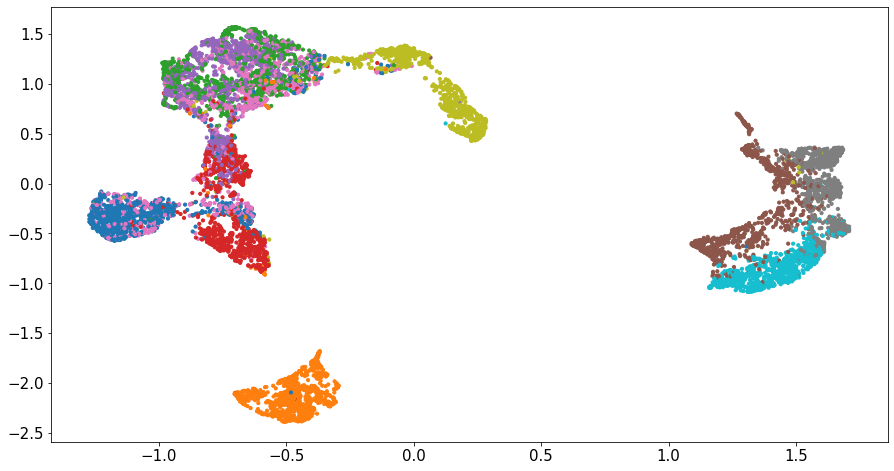

In [23]:
cmap = plt.cm.tab10

plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_test, s=10, cmap=cmap);

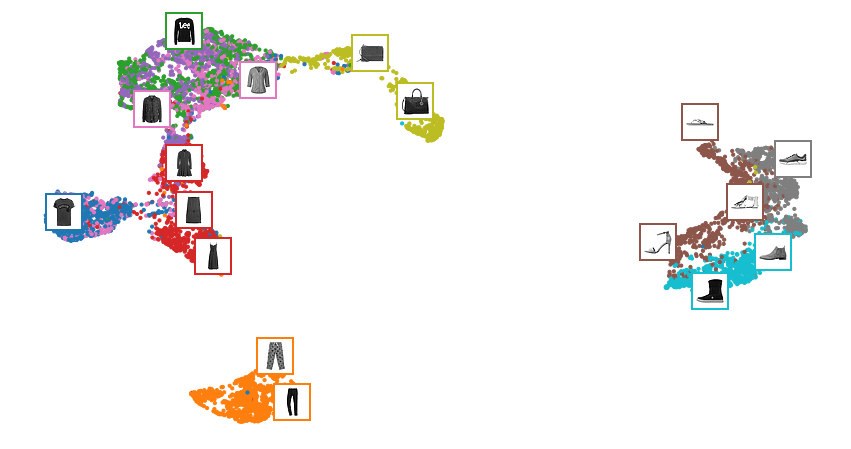

In [24]:
min_dist = 0.2

# from https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
cmap = plt.cm.tab10
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_test, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(embeddings_2d):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > min_dist: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_test[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_test[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off");

## Noisy Images

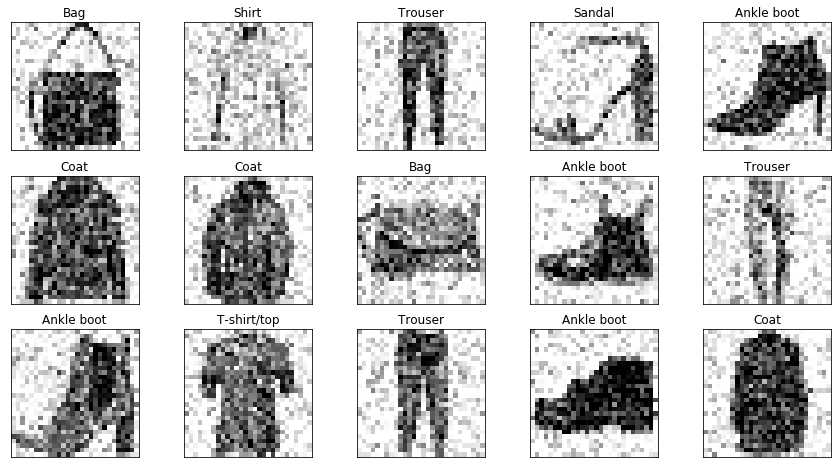

In [29]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

plot_samples(x_train_noisy, y_train, labels=fashion_mnist_labels)

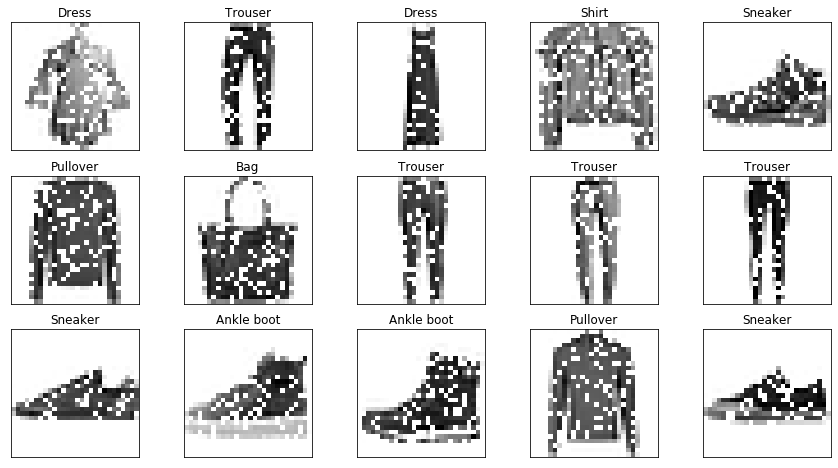

In [48]:
noise = keras.layers.GaussianNoise(0.2)
dropout = keras.layers.Dropout(0.2)

x_train_noisy = dropout(x_train, training=True).numpy()
x_test_noisy = dropout(x_test, training=True).numpy()

plot_samples(x_train_noisy, y_train, labels=fashion_mnist_labels)

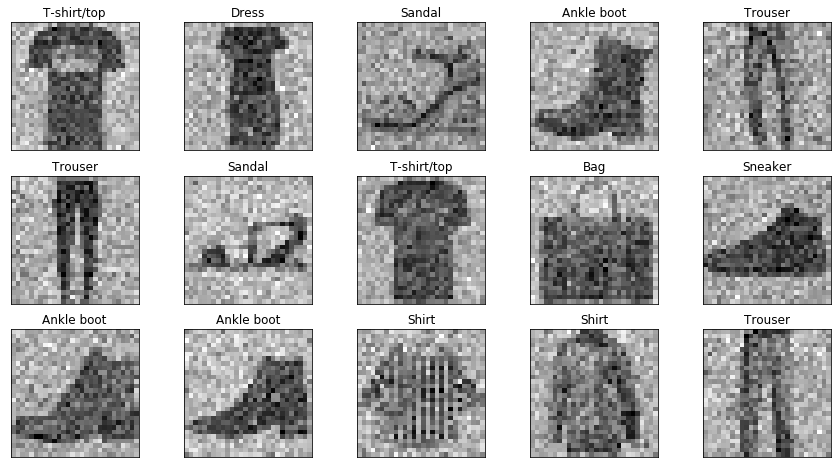

In [59]:
noise = keras.layers.GaussianNoise(0.2)

x_train_noisy = noise(x_train, training=True).numpy()
x_test_noisy = noise(x_test, training=True).numpy()

plot_samples(x_train_noisy, y_train, labels=fashion_mnist_labels)

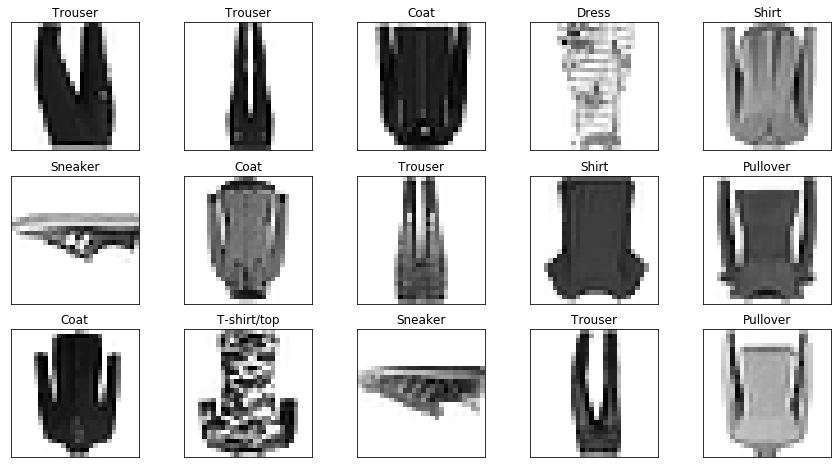

In [81]:
x_train_noisy = tf.image.flip_left_right(x_train).numpy()
x_test_noisy = tf.image.flip_left_right(x_test).numpy()

plot_samples(x_train_noisy, y_train, labels=fashion_mnist_labels)

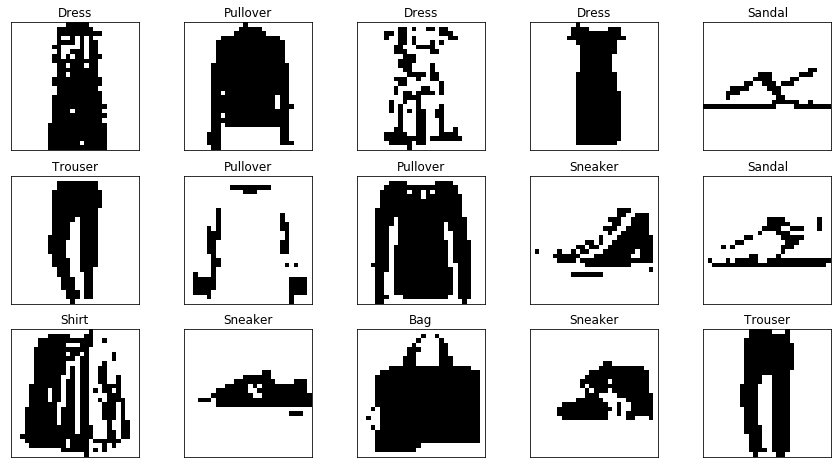

In [108]:
x_train_noisy = (x_train > 0.5).astype(float)
x_test_noisy =  (x_test > 0.5).astype(float)

plot_samples(x_train_noisy, y_train, labels=fashion_mnist_labels)

In [109]:
%%time

BATCH_SIZE = 256
EPOCHS = 50

denoising_ae = Sequential([conv_encoder, conv_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer='adam', metrics=[rounded_accuracy])

history = denoising_ae.fit(x = x_train_noisy,
                    y = x_train,
                    validation_data=(x_test_noisy, x_test),
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 1min 46s, sys: 10.9 s, total: 1min 57s
Wall time: 1min 28s


In [110]:
denoising_ae.evaluate(x = x_train_noisy, y = x_train, batch_size=BATCH_SIZE, verbose=0)

[0.28046041882832845, 0.9523551]

### Nosiy denoised

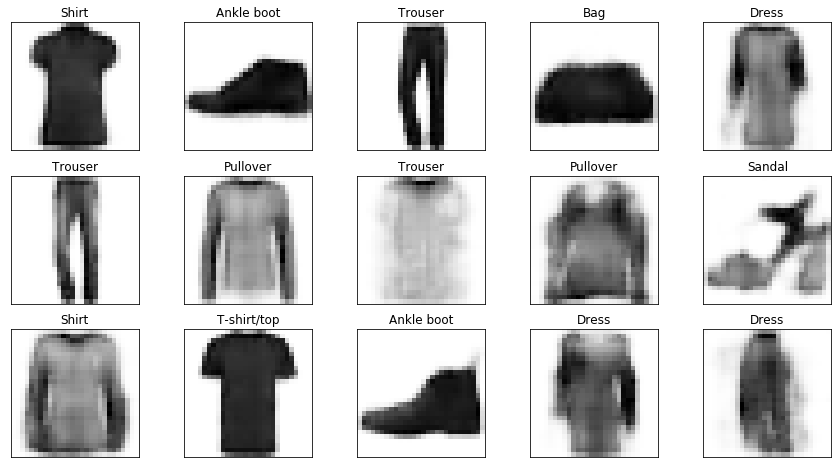

In [111]:
x_test_pred = denoising_ae.predict(x_test_noisy)
plot_samples(x_test_pred, y_test, labels=fashion_mnist_labels)
# plot_samples(x_test_pred, y_test)

### Original "denoised"

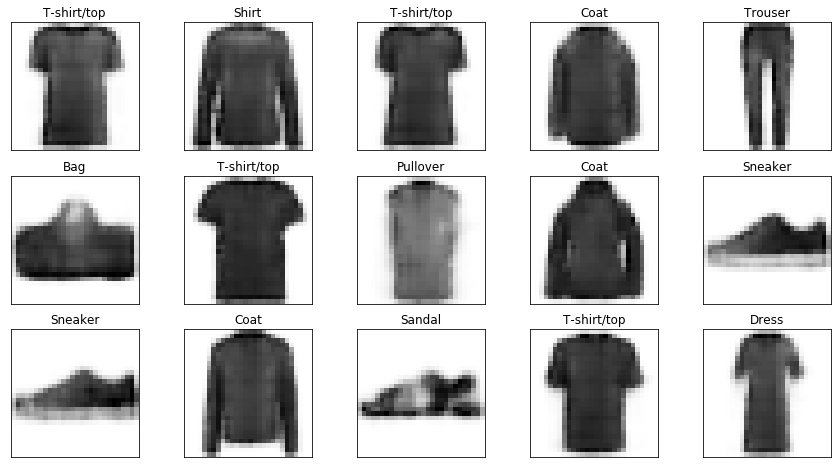

In [112]:
x_test_pred = denoising_ae.predict(x_test)
plot_samples(x_test_pred, y_test, labels=fashion_mnist_labels)
# plot_samples(x_test_pred, y_test)

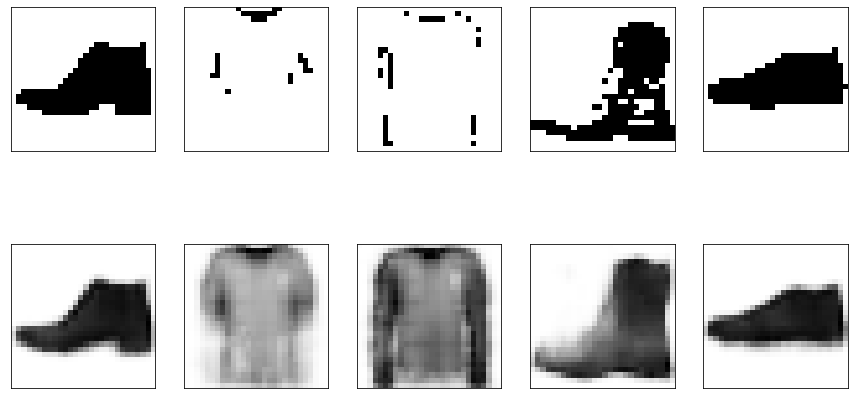

In [114]:
x_test_pred = denoising_ae.predict(x_test_noisy)

compare_samples(x_test_noisy, x_test_pred)